In [2]:
import os
from datetime import datetime
import re
import random
from collections import Counter, defaultdict
import glob

import pandas as pd
from matplotlib import pyplot as plt, font_manager, rcParams

# Set random seed
SEED = 42
random.seed(SEED)

# Plot aksara font
FONT_PATH = "./fonts/Noto_Sans_Javanese/static/NotoSansJavanese-Regular.ttf"
font_manager.fontManager.addfont(FONT_PATH)
rcParams["font.family"] = font_manager.FontProperties(fname=FONT_PATH).get_name()


In [3]:
TOTAL_CSV = 8
ROWS_PER_CSV = 50
TOTAL_SAMPLE = TOTAL_CSV * ROWS_PER_CSV

CONFIG = {
    "min_word": 2,
    "max_word": 6,
}

BASE_DIR = f"./data/word_nglegena_handwritten_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(BASE_DIR, exist_ok=True)


NGLEGENA = [
    ("ꦲ","ha"), ("ꦤ","na"), ("ꦕ","ca"), ("ꦫ","ra"), ("ꦏ","ka"),
    ("ꦢ","da"), ("ꦠ","ta"), ("ꦱ","sa"), ("ꦮ","wa"), ("ꦭ","la"),
    ("ꦥ","pa"), ("ꦝ","dha"), ("ꦗ","ja"), ("ꦪ","ya"), ("ꦚ","nya"),
    ("ꦩ","ma"), ("ꦒ","ga"), ("ꦧ","ba"), ("ꦛ","tha"), ("ꦔ","nga"),
]


In [4]:
def generate_word(cfg):
    length = random.randint(cfg["min_word"], cfg["max_word"])
    jawa, latin = "", ""

    for _ in range(length):
        aks, lat = random.choice(NGLEGENA)
        jawa += aks
        latin += lat

    return jawa, latin, length


def generate_dataset(total, cfg, coverage):
    rows = []
    seen_words = set()
    idx = 0

    while len(rows) < total:
        jawa, latin, length = generate_word(cfg)

        if jawa in seen_words:
            continue
        seen_words.add(jawa)

        coverage["word"][length] += 1
        for aks in jawa:
            coverage["aksara"][aks] += 1

        rows.append({
            "image": f"h_img_{idx:05d}.png",
            "transcription": jawa,
            "transliteration": latin,
            "length": length,
        })
        idx += 1

    return pd.DataFrame(rows)



coverage = {
    "aksara": Counter({aks: 0 for aks, _ in NGLEGENA}),
    "word": Counter()
}
df = generate_dataset(TOTAL_SAMPLE, CONFIG, coverage)
print(f"Total generated samples: {len(df)}")



# Split & shuffle into multiple CSV files
assert len(df) == TOTAL_SAMPLE
groups = defaultdict(list)

for _, row in df.iterrows():
    groups[row["length"]].append(row)

for length in groups:
    random.shuffle(groups[length])

ordered_rows = []
for length in sorted(groups.keys()):
    ordered_rows.extend(groups[length])

random.shuffle(ordered_rows)

for i in range(TOTAL_CSV):
    start = i * ROWS_PER_CSV
    end = start + ROWS_PER_CSV

    bucket = ordered_rows[start:end]
    assert len(bucket) == ROWS_PER_CSV

    csv_df = pd.DataFrame(bucket)
    csv_path = os.path.join(BASE_DIR, f"label_{i+1}.csv")
    csv_df.to_csv(csv_path, index=False)

    print(f"Saved {len(csv_df)} samples to {csv_path}")


Total generated samples: 400
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_1.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_2.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_3.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_4.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_5.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_6.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_7.csv
Saved 50 samples to ./data/word_nglegena_handwritten_20260109_223334\label_8.csv


In [5]:
ALLOWED_CHARS = set([aks for aks, _ in NGLEGENA])
REQUIRED_COLS = {"image", "transcription", "transliteration", "length"}
ROWS_PER_CSV = 50


def validate_csv(csv_path):
    print(f"\nValidating file: {csv_path}")
    print("-" * 50)

    df = pd.read_csv(csv_path)

    print(f"Jumlah baris               : {len(df)}")
    if len(df) != ROWS_PER_CSV:
        print("Jumlah baris tidak sesuai")

    missing_cols = REQUIRED_COLS - set(df.columns)
    if missing_cols:
        print(f"Kolom wajib hilang       : {missing_cols}")
    else:
        print("Skema kolom              : valid")

    null_rows = df[df.isnull().any(axis=1)]
    print(f"Baris dengan nilai kosong  : {len(null_rows)}")

    dup_pair = df[df.duplicated(["image", "transcription"], keep="first")]
    dup_semantic = df[df.duplicated(["transcription", "transliteration"], keep="first")]

    print(f"Duplikat image–label       : {len(dup_pair)}")
    print(f"Duplikat semantic label    : {len(dup_semantic)}")

    length_mismatch = df[df["transcription"].str.len() != df["length"]]
    print(f"Length mismatch            : {len(length_mismatch)}")

    oov_counter = Counter()
    oov_rows = []

    for idx, text in df["transcription"].items():
        oov = [ch for ch in text if ch not in ALLOWED_CHARS]
        if oov:
            oov_rows.append(idx)
            oov_counter.update(oov)

    print(f"Baris mengandung OOV       : {len(oov_rows)}")
    if oov_counter:
        print("OOV aksara:")
        for ch, c in oov_counter.items():
            print(f"  '{ch}' : {c}x")

    ctrl_rows = df[df["transcription"].apply(
        lambda x: bool(re.search(r"[\u0000-\u001F\u007F]", x))
    )]
    print(f"Karakter kontrol tersembunyi : {len(ctrl_rows)}")

    problem_idx = set()
    problem_idx.update(null_rows.index)
    problem_idx.update(dup_pair.index)
    problem_idx.update(dup_semantic.index)
    problem_idx.update(length_mismatch.index)
    problem_idx.update(oov_rows)
    problem_idx.update(ctrl_rows.index)

    print(f"Total baris bermasalah     : {len(problem_idx)}")
    print(f"Total baris valid          : {len(df) - len(problem_idx)}")



csv_files = sorted(glob.glob(os.path.join(BASE_DIR, "label_*.csv")))
for csv_path in csv_files:
    validate_csv(csv_path)


Validating file: ./data/word_nglegena_handwritten_20260109_223334\label_1.csv
--------------------------------------------------
Jumlah baris               : 50
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 50

Validating file: ./data/word_nglegena_handwritten_20260109_223334\label_2.csv
--------------------------------------------------
Jumlah baris               : 50
Skema kolom              : valid
Baris dengan nilai kosong  : 0
Duplikat image–label       : 0
Duplikat semantic label    : 0
Length mismatch            : 0
Baris mengandung OOV       : 0
Karakter kontrol tersembunyi : 0
Total baris bermasalah     : 0
Total baris valid          : 50

Validating file: ./data/word_nglegena_handwritten_20260109_223334\label_3.csv
-----------------------------

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_1.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.90

DISTRIBUSI PANJANG KATA
 2 aksara |     9 baris |  18.00%
 3 aksara |    11 baris |  22.00%
 4 aksara |    14 baris |  28.00%
 5 aksara |     8 baris |  16.00%
 6 aksara |     8 baris |  16.00%


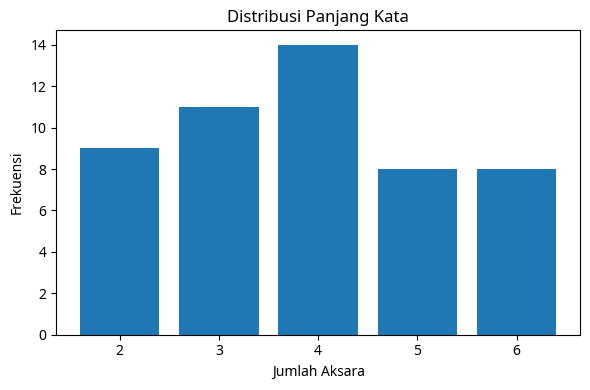

DISTRIBUSI AKSARA
  ꦲ (ha ) |      9 |   4.62%
  ꦤ (na ) |     10 |   5.13%
  ꦕ (ca ) |      9 |   4.62%
  ꦫ (ra ) |     15 |   7.69%
  ꦏ (ka ) |     12 |   6.15%
  ꦢ (da ) |     11 |   5.64%
  ꦠ (ta ) |      7 |   3.59%
  ꦱ (sa ) |     10 |   5.13%
  ꦮ (wa ) |     12 |   6.15%
  ꦭ (la ) |     11 |   5.64%
  ꦥ (pa ) |      7 |   3.59%
  ꦝ (dha) |     11 |   5.64%
  ꦗ (ja ) |      7 |   3.59%
  ꦪ (ya ) |      8 |   4.10%
  ꦚ (nya) |     10 |   5.13%
  ꦩ (ma ) |     12 |   6.15%
  ꦒ (ga ) |      9 |   4.62%
  ꦧ (ba ) |     10 |   5.13%
  ꦛ (tha) |      6 |   3.08%
  ꦔ (nga) |      9 |   4.62%

Total aksara: 195


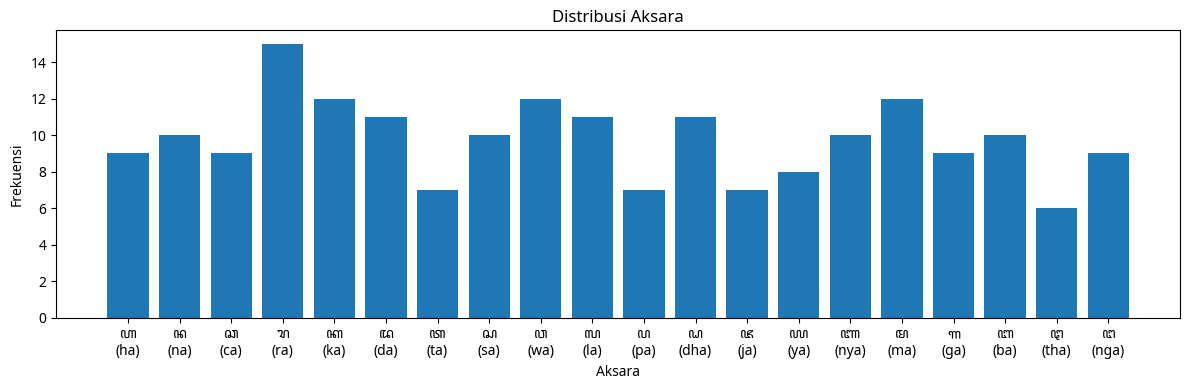

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_2.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.10

DISTRIBUSI PANJANG KATA
 2 aksara |     7 baris |  14.00%
 3 aksara |    10 baris |  20.00%
 4 aksara |    13 baris |  26.00%
 5 aksara |    11 baris |  22.00%
 6 aksara |     9 baris |  18.00%


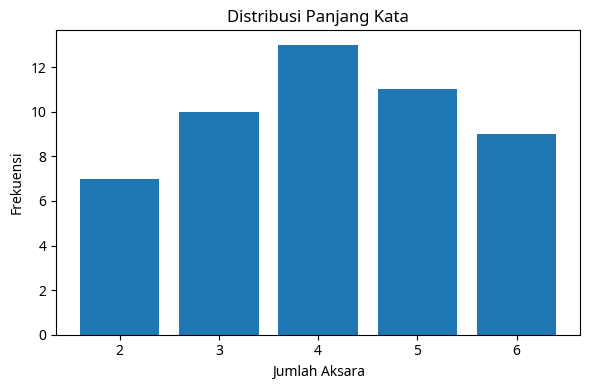

DISTRIBUSI AKSARA
  ꦲ (ha ) |     12 |   5.85%
  ꦤ (na ) |      9 |   4.39%
  ꦕ (ca ) |     13 |   6.34%
  ꦫ (ra ) |      9 |   4.39%
  ꦏ (ka ) |     13 |   6.34%
  ꦢ (da ) |     13 |   6.34%
  ꦠ (ta ) |      6 |   2.93%
  ꦱ (sa ) |     12 |   5.85%
  ꦮ (wa ) |     11 |   5.37%
  ꦭ (la ) |      6 |   2.93%
  ꦥ (pa ) |     11 |   5.37%
  ꦝ (dha) |     13 |   6.34%
  ꦗ (ja ) |      8 |   3.90%
  ꦪ (ya ) |      5 |   2.44%
  ꦚ (nya) |     15 |   7.32%
  ꦩ (ma ) |     10 |   4.88%
  ꦒ (ga ) |     10 |   4.88%
  ꦧ (ba ) |     10 |   4.88%
  ꦛ (tha) |     10 |   4.88%
  ꦔ (nga) |      9 |   4.39%

Total aksara: 205


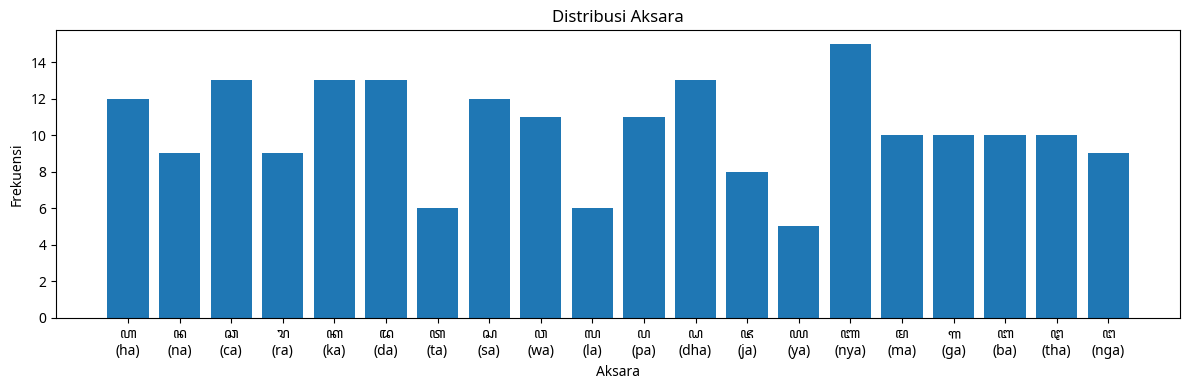

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_3.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.78

DISTRIBUSI PANJANG KATA
 2 aksara |    10 baris |  20.00%
 3 aksara |    14 baris |  28.00%
 4 aksara |     9 baris |  18.00%
 5 aksara |    11 baris |  22.00%
 6 aksara |     6 baris |  12.00%


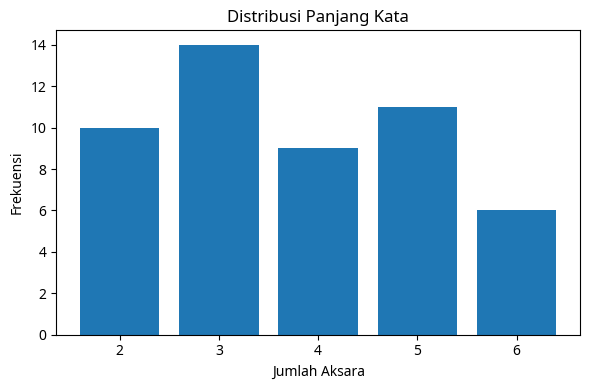

DISTRIBUSI AKSARA
  ꦲ (ha ) |      8 |   4.23%
  ꦤ (na ) |      9 |   4.76%
  ꦕ (ca ) |     13 |   6.88%
  ꦫ (ra ) |      8 |   4.23%
  ꦏ (ka ) |      8 |   4.23%
  ꦢ (da ) |      5 |   2.65%
  ꦠ (ta ) |      9 |   4.76%
  ꦱ (sa ) |     13 |   6.88%
  ꦮ (wa ) |     15 |   7.94%
  ꦭ (la ) |     12 |   6.35%
  ꦥ (pa ) |     11 |   5.82%
  ꦝ (dha) |     13 |   6.88%
  ꦗ (ja ) |      6 |   3.17%
  ꦪ (ya ) |      7 |   3.70%
  ꦚ (nya) |      9 |   4.76%
  ꦩ (ma ) |      6 |   3.17%
  ꦒ (ga ) |      7 |   3.70%
  ꦧ (ba ) |     10 |   5.29%
  ꦛ (tha) |     11 |   5.82%
  ꦔ (nga) |      9 |   4.76%

Total aksara: 189


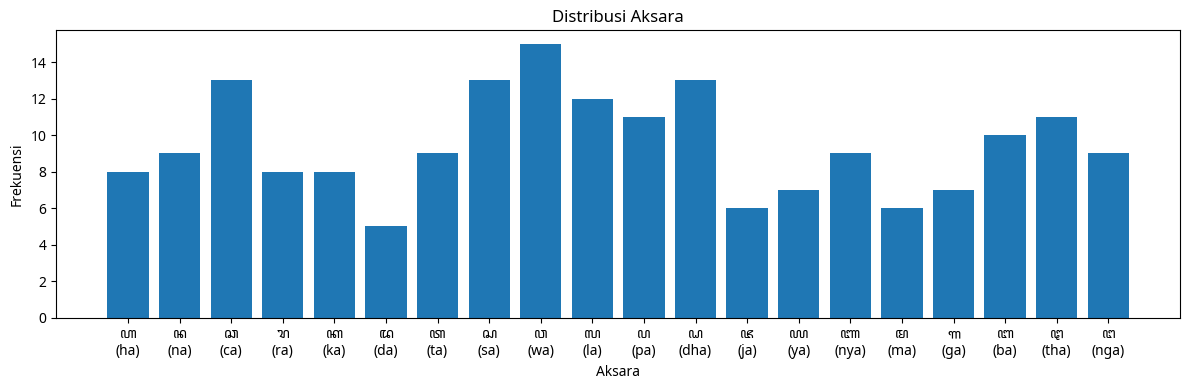

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_4.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.78

DISTRIBUSI PANJANG KATA
 2 aksara |    12 baris |  24.00%
 3 aksara |    13 baris |  26.00%
 4 aksara |     6 baris |  12.00%
 5 aksara |    12 baris |  24.00%
 6 aksara |     7 baris |  14.00%


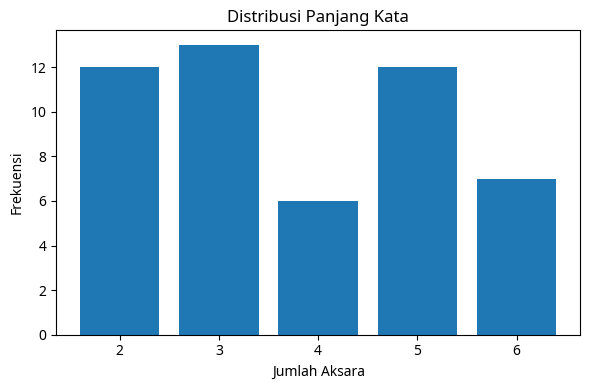

DISTRIBUSI AKSARA
  ꦲ (ha ) |      6 |   3.17%
  ꦤ (na ) |     13 |   6.88%
  ꦕ (ca ) |     12 |   6.35%
  ꦫ (ra ) |     10 |   5.29%
  ꦏ (ka ) |     11 |   5.82%
  ꦢ (da ) |      8 |   4.23%
  ꦠ (ta ) |      7 |   3.70%
  ꦱ (sa ) |     10 |   5.29%
  ꦮ (wa ) |     14 |   7.41%
  ꦭ (la ) |      8 |   4.23%
  ꦥ (pa ) |     13 |   6.88%
  ꦝ (dha) |      6 |   3.17%
  ꦗ (ja ) |     12 |   6.35%
  ꦪ (ya ) |      9 |   4.76%
  ꦚ (nya) |      9 |   4.76%
  ꦩ (ma ) |      8 |   4.23%
  ꦒ (ga ) |      9 |   4.76%
  ꦧ (ba ) |      8 |   4.23%
  ꦛ (tha) |      5 |   2.65%
  ꦔ (nga) |     11 |   5.82%

Total aksara: 189


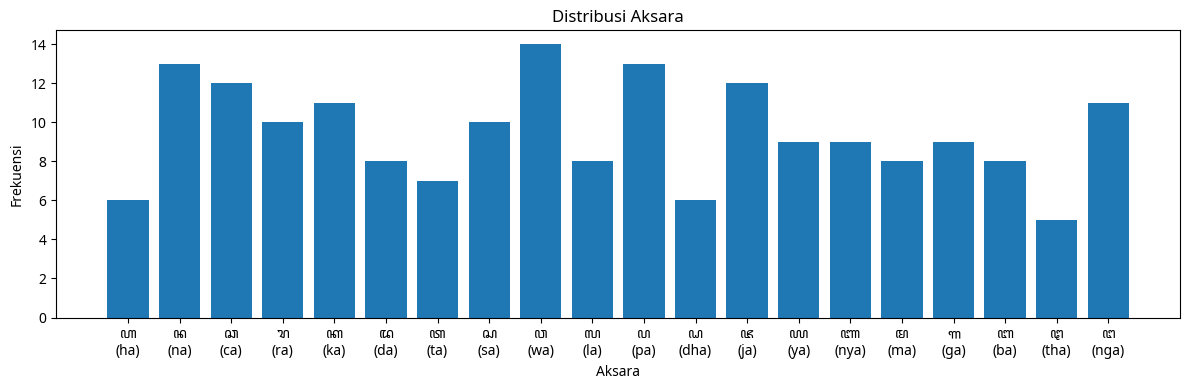

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_5.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.08

DISTRIBUSI PANJANG KATA
 2 aksara |    11 baris |  22.00%
 3 aksara |     8 baris |  16.00%
 4 aksara |    11 baris |  22.00%
 5 aksara |     6 baris |  12.00%
 6 aksara |    14 baris |  28.00%


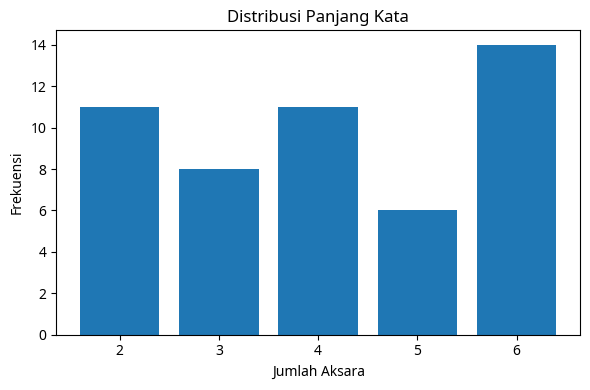

DISTRIBUSI AKSARA
  ꦲ (ha ) |      5 |   2.45%
  ꦤ (na ) |      7 |   3.43%
  ꦕ (ca ) |      9 |   4.41%
  ꦫ (ra ) |      7 |   3.43%
  ꦏ (ka ) |      7 |   3.43%
  ꦢ (da ) |      5 |   2.45%
  ꦠ (ta ) |      9 |   4.41%
  ꦱ (sa ) |     13 |   6.37%
  ꦮ (wa ) |      9 |   4.41%
  ꦭ (la ) |     14 |   6.86%
  ꦥ (pa ) |     11 |   5.39%
  ꦝ (dha) |      9 |   4.41%
  ꦗ (ja ) |      7 |   3.43%
  ꦪ (ya ) |     16 |   7.84%
  ꦚ (nya) |     17 |   8.33%
  ꦩ (ma ) |     13 |   6.37%
  ꦒ (ga ) |     10 |   4.90%
  ꦧ (ba ) |     15 |   7.35%
  ꦛ (tha) |     10 |   4.90%
  ꦔ (nga) |     11 |   5.39%

Total aksara: 204


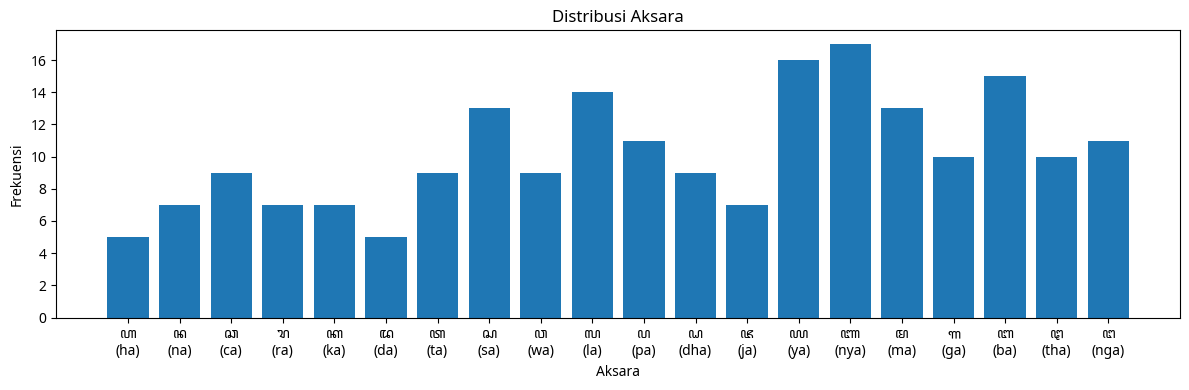

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_6.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 4.34

DISTRIBUSI PANJANG KATA
 2 aksara |     5 baris |  10.00%
 3 aksara |    13 baris |  26.00%
 4 aksara |     6 baris |  12.00%
 5 aksara |    12 baris |  24.00%
 6 aksara |    14 baris |  28.00%


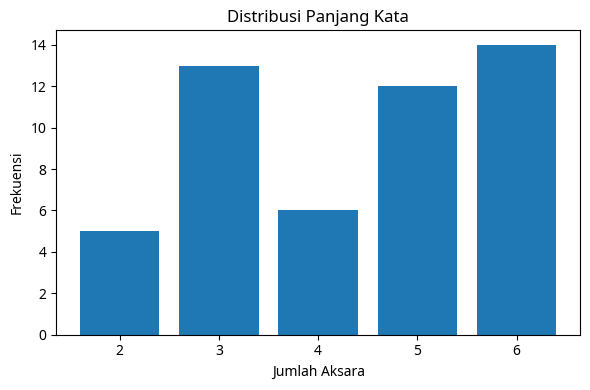

DISTRIBUSI AKSARA
  ꦲ (ha ) |     10 |   4.61%
  ꦤ (na ) |     13 |   5.99%
  ꦕ (ca ) |     10 |   4.61%
  ꦫ (ra ) |      9 |   4.15%
  ꦏ (ka ) |     10 |   4.61%
  ꦢ (da ) |      7 |   3.23%
  ꦠ (ta ) |     13 |   5.99%
  ꦱ (sa ) |      9 |   4.15%
  ꦮ (wa ) |      9 |   4.15%
  ꦭ (la ) |     16 |   7.37%
  ꦥ (pa ) |      7 |   3.23%
  ꦝ (dha) |     10 |   4.61%
  ꦗ (ja ) |     10 |   4.61%
  ꦪ (ya ) |     14 |   6.45%
  ꦚ (nya) |     10 |   4.61%
  ꦩ (ma ) |      5 |   2.30%
  ꦒ (ga ) |      8 |   3.69%
  ꦧ (ba ) |     16 |   7.37%
  ꦛ (tha) |     17 |   7.83%
  ꦔ (nga) |     14 |   6.45%

Total aksara: 217


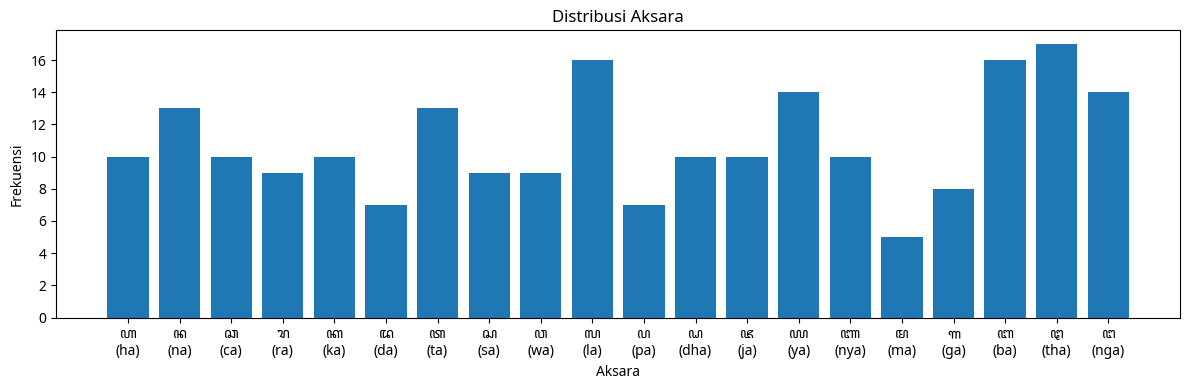

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_7.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.82

DISTRIBUSI PANJANG KATA
 2 aksara |    12 baris |  24.00%
 3 aksara |     9 baris |  18.00%
 4 aksara |    14 baris |  28.00%
 5 aksara |     6 baris |  12.00%
 6 aksara |     9 baris |  18.00%


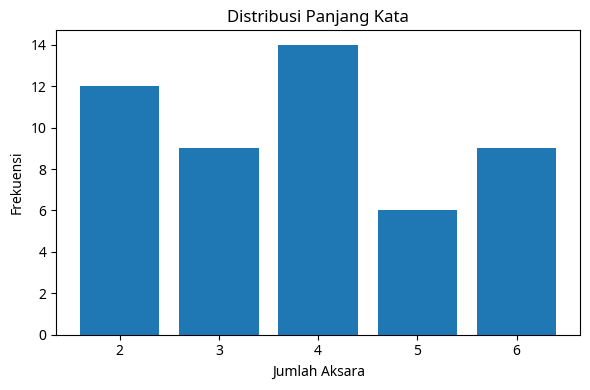

DISTRIBUSI AKSARA
  ꦲ (ha ) |      7 |   3.66%
  ꦤ (na ) |     10 |   5.24%
  ꦕ (ca ) |      9 |   4.71%
  ꦫ (ra ) |      4 |   2.09%
  ꦏ (ka ) |      9 |   4.71%
  ꦢ (da ) |      9 |   4.71%
  ꦠ (ta ) |      5 |   2.62%
  ꦱ (sa ) |      9 |   4.71%
  ꦮ (wa ) |      5 |   2.62%
  ꦭ (la ) |      9 |   4.71%
  ꦥ (pa ) |     10 |   5.24%
  ꦝ (dha) |      8 |   4.19%
  ꦗ (ja ) |     10 |   5.24%
  ꦪ (ya ) |     18 |   9.42%
  ꦚ (nya) |     17 |   8.90%
  ꦩ (ma ) |     10 |   5.24%
  ꦒ (ga ) |     10 |   5.24%
  ꦧ (ba ) |      5 |   2.62%
  ꦛ (tha) |     14 |   7.33%
  ꦔ (nga) |     13 |   6.81%

Total aksara: 191


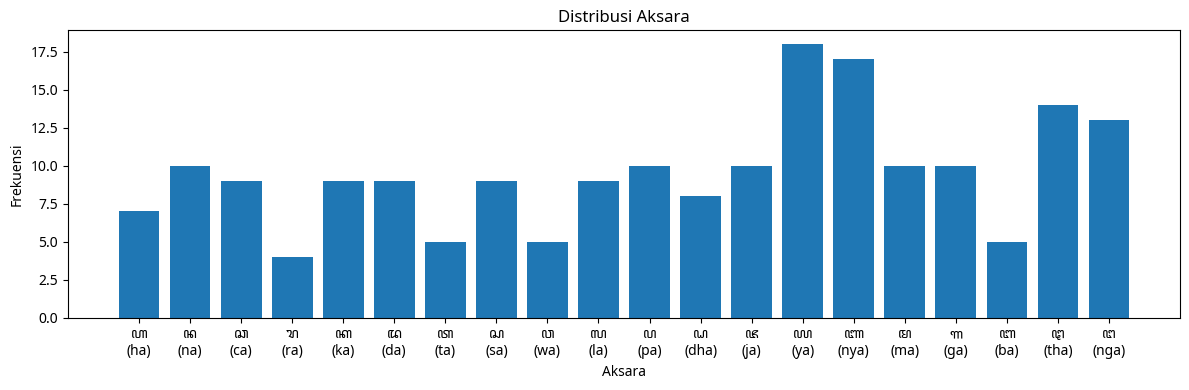

RINGKASAN DATA : ./data/word_nglegena_handwritten_20260109_223334\label_8.csv
Total kata            : 50
Min panjang kata      : 2
Max panjang kata      : 6
Rata-rata panjang     : 3.66

DISTRIBUSI PANJANG KATA
 2 aksara |    15 baris |  30.00%
 3 aksara |     7 baris |  14.00%
 4 aksara |    13 baris |  26.00%
 5 aksara |    10 baris |  20.00%
 6 aksara |     5 baris |  10.00%


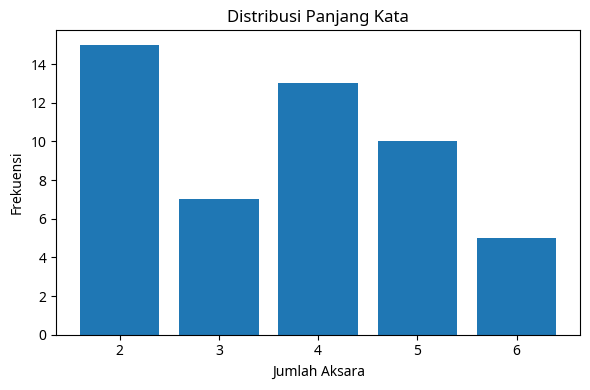

DISTRIBUSI AKSARA
  ꦲ (ha ) |      5 |   2.73%
  ꦤ (na ) |      9 |   4.92%
  ꦕ (ca ) |     13 |   7.10%
  ꦫ (ra ) |      9 |   4.92%
  ꦏ (ka ) |     14 |   7.65%
  ꦢ (da ) |      8 |   4.37%
  ꦠ (ta ) |      5 |   2.73%
  ꦱ (sa ) |      8 |   4.37%
  ꦮ (wa ) |      8 |   4.37%
  ꦭ (la ) |      6 |   3.28%
  ꦥ (pa ) |     12 |   6.56%
  ꦝ (dha) |      8 |   4.37%
  ꦗ (ja ) |     10 |   5.46%
  ꦪ (ya ) |      9 |   4.92%
  ꦚ (nya) |     12 |   6.56%
  ꦩ (ma ) |     10 |   5.46%
  ꦒ (ga ) |      8 |   4.37%
  ꦧ (ba ) |     11 |   6.01%
  ꦛ (tha) |      6 |   3.28%
  ꦔ (nga) |     12 |   6.56%

Total aksara: 183


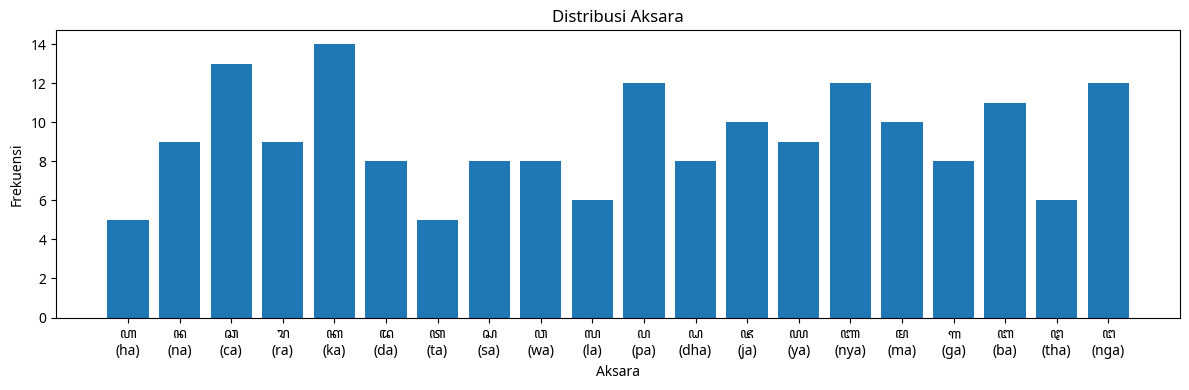

In [6]:
def plot_bar(x, y, title, xlabel, ylabel, figsize):
    plt.figure(figsize=figsize)
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def analyze_csv(
    csv_path,
    nglegena,
    show_plot=True,
):
    df = pd.read_csv(csv_path)
    latin_map = {aks: lat for aks, lat in nglegena}

    # ==============================
    # DATA SUMMARY
    # ==============================
    print("=" * 40)
    print(f"RINGKASAN DATA : {csv_path}")
    print("=" * 40)

    print(
        f"Total kata            : {len(df)}\n"
        f"Min panjang kata      : {df['length'].min()}\n"
        f"Max panjang kata      : {df['length'].max()}\n"
        f"Rata-rata panjang     : {df['length'].mean():.2f}\n"
    )

    # ==============================
    # WORD LENGTH DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI PANJANG KATA")
    print("=" * 40)

    length_dist = df["length"].value_counts().sort_index()
    total_words = len(df)

    for length, count in length_dist.items():
        pct = count / total_words * 100
        print(f"{length:>2} aksara | {count:5d} baris | {pct:6.2f}%")

    if show_plot:
        plot_bar(
            length_dist.index,
            length_dist.values,
            "Distribusi Panjang Kata",
            "Jumlah Aksara",
            "Frekuensi",
            (6, 4),
        )

    # ==============================
    # AKSARA DISTRIBUTION
    # ==============================
    print("=" * 40)
    print("DISTRIBUSI AKSARA")
    print("=" * 40)

    aksara_counter = Counter()
    for text in df["transcription"]:
        aksara_counter.update(text)

    aksara_dist = pd.DataFrame(
        [(aks, aksara_counter.get(aks, 0)) for aks, _ in nglegena],
        columns=["aksara", "count"],
    )
    aksara_dist["latin"] = aksara_dist["aksara"].map(latin_map)

    total_aksara = aksara_dist["count"].sum()

    for _, row in aksara_dist.iterrows():
        pct = (row["count"] / total_aksara * 100) if total_aksara else 0
        print(
            f"{row['aksara']:>3} ({row['latin']:<3}) | "
            f"{row['count']:6d} | {pct:6.2f}%"
        )

    print(f"\nTotal aksara: {total_aksara}")

    if show_plot:
        plot_bar(
            [f"{a}\n({latin_map[a]})" for a in aksara_dist["aksara"]],
            aksara_dist["count"],
            "Distribusi Aksara",
            "Aksara",
            "Frekuensi",
            (12, 4),
        )



csv_files = sorted(glob.glob(os.path.join(BASE_DIR, "label_*.csv")))
for csv_path in csv_files:
    analyze_csv(csv_path, NGLEGENA)
